In [59]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import Levenshtein
import matplotlib.pyplot as plt
import fastDamerauLevenshtein

### How does it work
Typos:
- previous and current values are splittet into words with non letters/whitespaces removed, if any are None or empty they are skipped
- only same wordcounts are tested (it is expected that words stay in the same order)
- words are compared to the words with the same index with Damerau-Levenshtein edit distance (swaps are cost 1 not 2)
- if any word has edit distance 1 or 2 it is further looked at
    1. test if first letter is a case swap (it is expected the user knows what is correct)
    2. test if previous word is not in a dictionary but current word is (comparison is done in lowercase)
- if any of the tests is true the change is marked as typo-fix

Swear words:
- previous and current values are splittet into words, if any are None or empty they are skipped
- words are compared to a swear word dictionary (https://github.com/RobertJGabriel/Google-profanity-words/blob/master/list.txt)
- if any word is matched the value is flagged as swear word
- if previous value has no swear word but current value has -> swear word added
- if previous value has a swear word but current value has not -> swear word deleted

In [60]:
# splits string in words
def split_strings(str1, str2):
    lst = [str1.split()]
    lst.append(str2.split())
    return lst

# checks if wordcount in both strings is equal


def same_wordcounts(lst1, lst2):
    return (len(lst1) == len(lst2))

# deletes non alphabetical characters from string


def skip_no_alpha(string):
    only_alpha = ""
    for char in string:
        if char.isalpha() or char == " ":
            only_alpha += char
    return only_alpha

# checks in numbers are increments


def is_increment(nr1, nr2):
    return (nr1+1 == nr2 or nr1-1 == nr2)

# checks if case (upper/loewr) of the first latter is switched


def is_first_letter_caseswitch(str1, str2):
    return (str1[0].isupper() and str2[0].islower() or str1[0].islower() and str2[0].isupper())


def is_not_empty_or_none(input):
    return input is not None and input is not ""


In [61]:
def get_levenshtein_dists(lst1, lst2):
    if len(lst1) != len(lst2):
        print("Difference words counts of lists!")
        return
    dists = []
    for i in range(len(lst1)):
            dists.append(int(fastDamerauLevenshtein.damerauLevenshtein(
                lst1[i], lst2[i], similarity=False)))
    return dists

# splits strings in words
def get_words_and_dists(str1, str2, only_alpha=False):
    if only_alpha:
        str1=skip_no_alpha(str1)
        str2=skip_no_alpha(str2)
    words = split_strings(str1, str2)
    if len(words[0]) == len(words[1]):
        dists = get_levenshtein_dists(words[0], words[1])
    else:
        dists = []
    return words, dists


In [62]:
def word_in_dict(str1, words_dict):
    return str1 in words_dict

def is_typo_fixed(str1, str2, words_dict, lowercase=True):
    """ Check if typo is fixed.
        return 0: no other case is found
        return 1: word was not in dict before (missspelled)
        return 2: word with swapped first letter (and other changes depending on edit distance)
    """
    # detects number errors (dreher,tippfehler), skipps increments. Only works if skip_no_alpha is false 
    if str1.isdigit() and str2.isdigit() and not is_increment(int(str1),int(str2)):
        return 3

    if is_first_letter_caseswitch(str1,str2):
        return 2

    if lowercase:
        str1=str1.lower()
        str2=str2.lower()

    # checks if str1 is not in dict but str2 is
    if (not word_in_dict(str1, words_dict) and word_in_dict(str2, words_dict)):
        return 1
        
    return 0

In [63]:
def get_typo_type(str1, str2, words_dict, upper_lev_distance=2, skip_no_alpha=False):
    words, levenshtein_dists = get_words_and_dists(
        str1, str2, skip_no_alpha)
    typo_lst = []
    for i in range(len(levenshtein_dists)):  # only loops if dists are found (word counts are equal)
        # only uses distances >0 <=2
        if(levenshtein_dists[i] > 0 and levenshtein_dists[i] <= upper_lev_distance):
            typo_lst.append(is_typo_fixed(
                words[0][i], words[1][i], words_dict))
        # else:  # appends None if dist is <0 or >2
        #     typo_lst.append(None)
    return typo_lst


In [64]:
my_file = open("../../../words_alpha.txt", "r")
words_dict=set(my_file.read().split("\n"))

testcase1 = ["Hier sind kkeine Fheler", "Hier sind keine Fehler"]
testcase1_en = ["There are nno erorrs", "There are no errors"]
typo_lst = get_typo_type(testcase1_en[0], testcase1_en[1], words_dict)
print(typo_lst)

[1, 1]


In [65]:
def typo_check(str1, str2, words_dict, upper_lev_distance=2, skip_no_alpha=False):
    """Return True if typo
       Return False if no typo
    """
    typo_lst = get_typo_type(str1, str2, words_dict, upper_lev_distance, skip_no_alpha)
    if len(typo_lst) == 0:
        return None
    for typo_type in typo_lst:
        if typo_type > 0:  # 1 is previous not in dict, current is in dict, 2 case switch on first letter
            return True
    return False


In [66]:
def count_typos(typo_lst):
    counts = {"typo fixed": 0,
              "no typo": 0,
              "no levenshstein match": 0,
              "not tested": 0
              }
    for typo in typo_lst:
        if typo is True:
            counts["typo fixed"] += 1
        if typo is False:
            counts["no typo"] += 1
        if typo is None:
            counts["no levenshstein match"] += 1
        if typo is "not_tested":
            counts["not tested"] += 1
    counts["tested"] = counts["typo fixed"] + \
        counts["no typo"]+counts["no levenshstein match"]
    print("typo fixed:", counts["typo fixed"])
    print("no typo:", counts["no typo"])
    print("no levenshstein match:", counts["no levenshstein match"])
    print("not tested:", counts["not tested"])
    print("total changes:", counts["typo fixed"]+counts["no typo"] +
          counts["not tested"]+counts["no levenshstein match"])
    print("% of matching levenshtein distance:",
          (counts["typo fixed"]+counts["no typo"])/counts["tested"]*100)
    print("typo fix % of tested changes (only updates without creations/deletions):",
          counts["typo fixed"]/counts["tested"]*100)
    print("typo fix % of all changes:",
          (counts["typo fixed"]/(counts["typo fixed"]+counts["no typo"]+counts["not tested"]))*100)


In [67]:
input_data = Path("../../matched-infoboxes-extracted/")
inp = list(input_data.rglob('*.json'))
files = [x for x in inp if x.is_file()]
print("number of files:", len(files))

number of files: 70


In [68]:
my_file = open("../../../words_alpha.txt", "r")
words_dict=set(my_file.read().split("\n"))

In [69]:
num_iteratons = 1
number_of_files =5
number_of_files_start = 5
num_edits = 0
num_change_tuples = 0
typo_lst = []
for _ in range(num_iteratons):
    change_tuples = []
    for file in tqdm(files[number_of_files_start:number_of_files_start+number_of_files]):
        with open(file, 'r', encoding='utf-8') as f:
            for jsonObj in f:
                single_edit = json.loads(jsonObj)
                num_edits += 1
                title = single_edit['pageTitle']
                pageID = single_edit['pageID']
                key = single_edit['key']
                template = single_edit['template'] if 'template' in single_edit.keys(
                ) else None
                changes = single_edit['changes']
                validFrom = single_edit['validFrom']
                revisionId = single_edit['revisionId']
                attributes = single_edit['attributes'] if 'attributes' in single_edit.keys(
                ) else None
                user_name = single_edit['user']['username'] if 'username' in single_edit['user'].keys(
                ) else None
                user_id = single_edit['user']['id'] if 'id' in single_edit['user'].keys(
                ) else None
                user_ip = single_edit['user']['ip'] if 'ip' in single_edit['user'].keys(
                ) else None
                for change in changes:
                    num_change_tuples += 1
                    name = change['property']['name']
                    current_value = change['currentValue'] if 'currentValue' in change.keys(
                    ) else None
                    previous_value = change['previousValue'] if 'previousValue' in change.keys(
                    ) else None
                    validTo = change['valueValidTo'] if 'valueValidTo' in change.keys(
                    ) else None
                    change_tuples.append((title, pageID, key, template, name, previous_value,
                                          current_value, validFrom, validTo, revisionId, user_name, user_id, user_ip, attributes))
    number_of_files_start += number_of_files

    upper_lev_dist=2
    for i in tqdm(range(len(change_tuples))):
        # Check only changes (no creations/deletions)
        if(is_not_empty_or_none(change_tuples[i][5]) and is_not_empty_or_none(change_tuples[i][6])):
            typo_lst.append(typo_check(
                change_tuples[i][5], change_tuples[i][6], words_dict, upper_lev_dist, True))
        else:
            typo_lst.append("not_tested")
print("Read data:")
print("Number of edits:", num_edits)
print("Number of change tuples:", num_change_tuples)
print("\nProcessed data:")
count_typos(typo_lst)

100%|██████████| 1220624/1220624 [00:08<00:00, 149711.50it/s]


Read data:
Number of edits: 226116
Number of change tuples: 1220624

Processed data:
typo fixed: 6478
no typo: 14863
no levenshstein match: 232534
not tested: 966749
total changes: 1220624
% of matching levenshtein distance: 8.406105366814378
typo fix % of tested changes (only updates without creations/deletions): 2.551649433776465
typo fix % of all changes: 0.6556082947909604


In [70]:
# get idx of all fixed typos
typo_idx = []
for i in range(len(typo_lst)):
    if typo_lst[i] == True:
        typo_idx.append(i)

matching_lev_idx = []
for i in range(len(typo_lst)):
    if typo_lst[i] == True or typo_lst[i] == False:
        matching_lev_idx.append(i)

all_updates_idx = []
for i in range(len(typo_lst)):
    if typo_lst[i] != "not tested":
        all_updates_idx.append(i)

## Time to Change

In [71]:
from datetime import datetime

def timedeltas_between_changes(typo_idx, change_tuples):
    time_deltas = []
    for idx in typo_idx:
        if change_tuples[idx][7] is not None and change_tuples[idx][8] is not None:
            time_delta = datetime.strptime(change_tuples[idx][8], '%Y-%m-%dT%H:%M:%SZ')-datetime.strptime(
                change_tuples[idx][7], '%Y-%m-%dT%H:%M:%SZ')
            time_deltas.append(time_delta)
    return time_deltas

In [72]:
import numpy as np

def timedelta_to_seconds(arr): return arr.total_seconds()
def timedelta_to_hours(arr): return arr.total_seconds()/60/60
def timedelta_to_days(arr): return arr.total_seconds()/60/60/24
def timedelta_to_days_int(arr): return arr.days

timedelta_to_seconds = np.vectorize(timedelta_to_seconds)
timedelta_to_hours = np.vectorize(timedelta_to_hours)
timedelta_to_days = np.vectorize(timedelta_to_days)
timedelta_to_days_int = np.vectorize(timedelta_to_days_int)

In [73]:
# fixed typos
time_deltas = timedeltas_between_changes(typo_idx, change_tuples)
time_deltas = np.array(time_deltas)
print("Average Time to change for a typofix")
print("Median time in days", np.median(timedelta_to_days(time_deltas)))
print("Median time in hours", np.median(timedelta_to_hours(time_deltas)))
print("Median time in seconds", np.median(timedelta_to_seconds(time_deltas)))
print("timedelta mean and std in days:", np.mean(
    timedelta_to_days(time_deltas)), np.std(timedelta_to_days(time_deltas)))
print("timedelta mean:", str(time_deltas.mean()))
print("number of samples:", len(time_deltas))


Average Time to change for a typofix
Median time in days 15.225462962962961
Median time in hours 365.4111111111111
Median time in seconds 1315480.0
timedelta mean and std in days: 121.4773199017615 315.35670306000645
timedelta mean: 121 days, 11:27:20.439512
number of samples: 6150


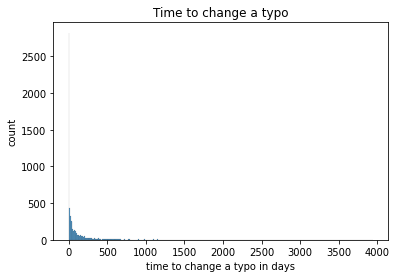

In [74]:
import seaborn as sns

ax = sns.histplot(timedelta_to_days(time_deltas))
ax.set(xlabel='time to change a typo in days', ylabel='count', title='Time to change a typo')
plt.show()

In [75]:
# matching levenshtein distance
time_deltas_lev = timedeltas_between_changes(matching_lev_idx, change_tuples)
time_deltas_lev = np.array(time_deltas_lev)
print("Average Time to change for a typofix")
print("Median time in days", np.median(timedelta_to_days(time_deltas_lev)))
print("Median time in hours", np.median(timedelta_to_hours(time_deltas_lev)))
print("Median time in seconds", np.median(timedelta_to_seconds(time_deltas_lev)))
print("timedelta mean and std in days:", np.mean(
    timedelta_to_days(time_deltas_lev)), np.std(timedelta_to_days(time_deltas_lev)))
print("timedelta mean:", str(time_deltas_lev.mean()))
print("number of samples:",len(time_deltas_lev))

Average Time to change for a typofix
Median time in days 3.7322106481481483
Median time in hours 89.57305555555556
Median time in seconds 322463.0
timedelta mean and std in days: 89.94200736625214 259.5089196133565
timedelta mean: 89 days, 22:36:29.436444
number of samples: 20541


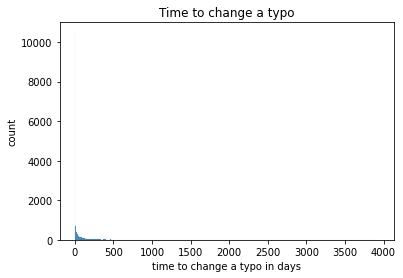

In [76]:
ax = sns.histplot(timedelta_to_days(time_deltas_lev))
ax.set(xlabel='time to change a typo in days', ylabel='count', title='Time to change a typo')
plt.show()

In [77]:
# all tested data
time_deltas_tested = timedeltas_between_changes(all_updates_idx, change_tuples)
time_deltas_tested = np.array(time_deltas_tested)
print("Average Time to change for a typofix")
print("Median time in days", np.median(timedelta_to_days(time_deltas_tested)))
print("Median time in hours", np.median(timedelta_to_hours(time_deltas_tested)))
print("Median time in seconds", np.median(timedelta_to_seconds(time_deltas_tested)))
print("timedelta mean and std in days:", np.mean(
    timedelta_to_days(time_deltas_tested)), np.std(timedelta_to_days(time_deltas_tested)))
print("timedelta mean:", str(time_deltas_tested.mean()))
print("number of samples:",len(time_deltas_tested))

Average Time to change for a typofix
Median time in days 0.06587962962962962
Median time in hours 1.581111111111111
Median time in seconds 5692.0
timedelta mean and std in days: 67.06898267465179 245.769956857893
timedelta mean: 67 days, 1:39:20.103090
number of samples: 1161035


## Dataframe

In [78]:
data = pd.DataFrame(change_tuples, columns=['pageTitle', 'pageID', 'key', 'template', 'name', 'previous_value',
                    'current_value', 'validFrom', 'validTo', 'revisionId', 'user_name', 'user_id', 'user_ip', 'attributes'])
data['validFrom'] = pd.to_datetime(data['validFrom'])
data['validTo'] = pd.to_datetime(data['validTo'])

In [79]:
data.iloc[typo_idx].head(50)

,pageTitle,pageID,key,template,name,previous_value,current_value,validFrom,validTo,revisionId,user_name,user_id,user_ip,attributes
231,Indonesian National Armed Forces,14650,119306865-0,infobox national military,branches,{{nowrap|[[File:Logo Indonesian Army.jpg|25px|...,{{nowrap|[[File:Logo Indonesian Army.jpg|25px|...,2010-10-12 02:30:47+00:00,2012-11-23 10:36:45+00:00,390192483,Yobot,7328338.0,None,"{'country': 'Indonesia', 'domestic_suppliers':..."
417,Indonesian National Armed Forces,14650,119306865-0,infobox national military,deployed,"1,673<ref>{{cite web|url=http://www.pkc-indone...","1,673<ref>{{cite web|url=http://www.pkc-indone...",2015-01-03 09:11:59+00:00,2016-11-07 04:32:17+00:00,640775490,Yobot,7328338.0,None,"{'country': 'Indonesia', 'domestic_suppliers':..."
453,Indonesian National Armed Forces,14650,119306865-0,infobox national military,history,[[Military history of Indonesia]]<br>[[History...,[[Military history of Indonesia]]<br>[[History...,2015-09-23 13:25:35+00:00,2016-01-20 09:16:50+00:00,682397136,Muffin Wizard,15954718.0,None,"{'country': 'Indonesia', 'domestic_suppliers':..."
645,International Standard Book Number,14919,610935337-0,infobox identifier,check_digit,weighted sum,Weighted sum,2014-05-31 16:18:52+00:00,2014-11-10 23:59:07+00:00,610945771,Pigsonthewing,26248.0,None,"{'image': 'EAN-13-ISBN-13.svg', 'check_digit':..."
710,International Standard Book Number,14919,610935337-0,infobox identifier,name,International Standard Bok Number,International Standard Book Number,2015-10-11 12:34:25+00:00,2015-10-15 00:04:48+00:00,685193495,Mr Stephen,863017.0,None,"{'image': 'EAN-13-ISBN-13.svg', 'check_digit':..."
840,International Standard Book Number,14919,610935337-0,infobox identifier,image_caption,"A 13-digit ISBN, 978-3-16-148410-0, as represe...","A 13-digit ISBN, 978-3-16-148410-0, as represe...",2016-06-13 01:57:53+00:00,2016-07-24 13:31:10+00:00,725018955,HMSLavender,21479757.0,None,"{'image': 'EAN-13-ISBN-13.svg', 'check_digit':..."
948,Isaiah,15088,420185856-0,infobox saint,image,Isqaiah (Bible Card).jpg,Isaiah (Bible Card).jpg,2012-12-12 15:09:54+00:00,2013-07-01 03:03:59+00:00,527708763,Lindert,6890959.0,None,"{'image': 'Isaiah (Bible Card).jpg', 'prayer_a..."
1118,Isaiah,15088,420185856-0,infobox saint,name,Isaiak,Isaiah,2016-03-08 16:21:35+00:00,2016-05-02 07:20:36+00:00,708994985,ClueBot NG,13286072.0,None,"{'image': 'Isaiah (Bible Card).jpg', 'prayer_a..."
1119,Isaiah,15088,420185856-0,infobox saint,death_date,7th Century BCE,7th century BC,2016-03-17 05:42:24+00:00,2016-03-17 05:56:40+00:00,710482381,None,NaN,142.68.43.177,"{'image': 'Isaiah (Bible Card).jpg', 'prayer_a..."
1120,Isaiah,15088,420185856-0,infobox saint,birth_date,8th Century BCE,8th century BC,2016-03-17 05:42:24+00:00,2016-03-17 05:56:40+00:00,710482381,None,NaN,142.68.43.177,"{'image': 'Isaiah (Bible Card).jpg', 'prayer_a..."


## Swear words

In [80]:
def check_swear(str1, str2, words_dict, lowercase=True):
    """ Check if swear got added or removed.
        Input:
            str1: prev string
            str2: curr string
        Output:
        prev false , curr true : 1 (swear word added)
        prev true , curr false : 2 (swear word removed)
    """
    if lowercase:
        str1=str1.lower()
        str2=str2.lower()

    str1_lst=str1.split()
    str2_lst=str2.split()

    prev_swear=False
    curr_swear=False
    for string in str1_lst:
        if word_in_dict(string, words_dict):
            prev_swear=True
            break

    for string in str2_lst:
        if word_in_dict(string, words_dict):
            curr_swear=True
            break

    if (not prev_swear and curr_swear):
        # swear word added
        return 1
    if (prev_swear and not curr_swear):
        # swear word removed
        return 2
    if (prev_swear and  curr_swear):
        # swear word in both
        return 3
    if (not prev_swear and not curr_swear):
        # swear word in none
        return 0

In [81]:
swear_file = open("../../../words_swear.txt", "r")
swear_dict = set(swear_file.read().split("\n"))
swear_dict.remove("nazi") # nazi is mostly no swear word in the context

def is_not_empty_or_none(input):
    return input is not None and input is not ""


swear_lst = []
for i in tqdm(range(len(change_tuples))):
    if(is_not_empty_or_none(change_tuples[i][5]) and is_not_empty_or_none(change_tuples[i][6])):
        swear_lst.append(check_swear(
            change_tuples[i][5], change_tuples[i][6], swear_dict))
    else:
        swear_lst.append(None)


counts_swear = {"Swearwords added": 0,
                "Swearwords removed": 0,
                "Swearwords not touched": 0,
                "Swearwords not found": 0,
                "create or delete (skipped)": 0}
for test in swear_lst:
    if test is 1:
        counts_swear["Swearwords added"] += 1
    if test is 2:
        counts_swear["Swearwords removed"] += 1
    if test is 3:
        counts_swear["Swearwords not touched"] += 1
    if test is 0:
        counts_swear["Swearwords not found"] += 1
    if test is None:
        # prev or curr is None
        counts_swear["create or delete (skipped)"] += 1
print(counts_swear)

idx_swear = [[], []]
for i in range(len(swear_lst)):
    if swear_lst[i] == 1:
        idx_swear[0].append(i)
    if swear_lst[i] == 2:
        idx_swear[1].append(i)


100%|██████████| 1220624/1220624 [00:02<00:00, 599920.29it/s]


{'Swearwords added': 2382, 'Swearwords removed': 2338, 'Swearwords not touched': 215, 'Swearwords not found': 248940, 'create or delete (skipped)': 966749}


In [82]:
print("Swearwords added:", counts_swear["Swearwords added"])
print("Swearwords removed:", counts_swear["Swearwords removed"])
print("Swearwords not touched:", counts_swear["Swearwords not touched"])
print("Swearwords not found:", counts_swear["Swearwords not found"])
print("create or delete (skipped):", counts_swear["create or delete (skipped)"])
edit_count = counts_swear["Swearwords added"]+counts_swear["Swearwords removed"] + \
    counts_swear["Swearwords not touched"]+counts_swear["Swearwords not found"]
print("Toal tuples (only updates without creations/deletions):", edit_count)
print("Toal tuples:", edit_count+counts_swear["create or delete (skipped)"])
print("Percentage of swear words in edits (only updates without creations/deletions) added and removed:",
      counts_swear["Swearwords added"]/edit_count, counts_swear["Swearwords removed"]/edit_count)


Swearwords added: 2382
Swearwords removed: 2338
Swearwords not touched: 215
Swearwords not found: 248940
create or delete (skipped): 966749
Toal tuples (only updates without creations/deletions): 253875
Toal tuples: 1220624
Percentage of swear words in edits (only updates without creations/deletions) added and removed: 0.009382570162481537 0.009209256523879862


## Swear words added

In [83]:
time_deltas_swear = timedeltas_between_changes(idx_swear[0], change_tuples)
time_deltas_swear = np.array(time_deltas_swear)
print("Average Time to change for a typofix")
print("Median time in days", np.median(timedelta_to_days(time_deltas_swear)))
print("Median time in hours", np.median(timedelta_to_hours(time_deltas_swear)))
print("Median time in seconds", np.median(timedelta_to_seconds(time_deltas_swear)))
print("timedelta mean and std in days:", np.mean(
    timedelta_to_days(time_deltas_swear)), np.std(timedelta_to_days(time_deltas_swear)))
print("timedelta mean:", str(time_deltas_swear.mean()))

Average Time to change for a typofix
Median time in days 0.0005555555555555556
Median time in hours 0.013333333333333334
Median time in seconds 48.0
timedelta mean and std in days: 0.7605434803761308 10.933354416187766
timedelta mean: 18:15:10.956704


In [84]:
def removeOutliers(data, percentile):
    lower_quartile = np.percentile(data, percentile)
    upper_quartile = np.percentile(data, 100-percentile)
    if lower_quartile == upper_quartile:
        return data
    print(lower_quartile, upper_quartile)
    data = data[data >= lower_quartile]
    data = data[data < upper_quartile]
    return data

In [85]:
# 
# ax = sns.histplot(timedelta_to_hours(time_deltas_swear))
# ax.set(xlabel='time to remove a swear word in days', ylabel='count', title='Time to remove a swear word')
# plt.show()

In [86]:
data.iloc[idx_swear[0]].head(10)

,pageTitle,pageID,key,template,name,previous_value,current_value,validFrom,validTo,revisionId,user_name,user_id,user_ip,attributes
1023,Isaiah,15088,420185856-0,infobox saint,name,Isaiah,mr butt cheeks,2014-05-12 15:19:03+00:00,2014-05-12 15:19:07+00:00,608235135,None,NaN,173.13.101.29,"{'image': 'Isaiah (Bible Card).jpg', 'prayer_a..."
2437,Demographics of India,14598,235701605-0,infobox country demographics,infant_mortality,"41 deaths/1,000 live births<ref name=NFHS_IV>[...","41 deaths/1,000 live births (2016 est.)<ref>{{...",2017-06-07 10:51:30+00:00,2017-10-26 04:48:57+00:00,784265925,JayB91,20257305.0,None,"{'country': 'India', 'image': 'File:India popu..."
2884,Demographics of India,14598,235701605-0,infobox country demographics,caption,Map showing the population density of each dis...,Map showing the gay sex ratio of each district...,2019-08-05 07:29:06+00:00,2019-08-05 07:30:22+00:00,909409640,None,NaN,150.242.74.114,"{'country': 'Wakanda', 'image': 'File:India po..."
5417,Iran–Iraq War,14889,31906363-0,infobox military conflict,conflict,Iran-Iraq War,Fuck Iraq,2006-07-05 10:14:59+00:00,2006-07-05 10:15:04+00:00,62160378,None,NaN,220.247.234.107,{'date': '[[22 September]] [[1980]]–[[20 Augus...
7696,Iran–Iraq War,14889,31906363-0,infobox military conflict,result,Stalemate\n*Strategic Iraqi failure\n*Tactical...,Stalemate\n*Strategic your mama\n*Tactical suc...,2009-11-10 06:41:57+00:00,2009-11-10 12:51:50+00:00,325002769,None,NaN,203.59.129.187,"{'date': '22 September 1980 – 20 August 1988',..."
7968,Iran–Iraq War,14889,31906363-0,infobox military conflict,caption,Clockwise from above: Iranian soldiers wearing...,Clockwise from above: Iranian soldiers wearing...,2010-04-30 21:33:09+00:00,2010-04-30 21:35:50+00:00,359330510,None,NaN,205.155.24.122,"{'date': '22 September 1980 – 20 August 1988',..."
7996,Iran–Iraq War,14889,31906363-0,infobox military conflict,caption,Clockwise from above: Iranian soldiers wearing...,Clockwise from above: Iranian soldiers wearing...,2010-05-16 19:08:10+00:00,2010-05-16 19:57:46+00:00,362479043,None,NaN,65.11.249.160,"{'date': '22 September 1980 – 20 August 1988',..."
9086,Iran–Iraq War,14889,31906363-0,infobox military conflict,territory,''[[Status quo ante bellum]]''; observed by [[...,''[[Status quo ante bellum]]''; observed by [[...,2013-02-11 20:03:00+00:00,2013-02-11 20:25:01+00:00,537755803,None,NaN,12.249.129.38,{'date': '22 September 1980&nbsp;– 20 August 1...
9636,Iran–Iraq War,14889,31906363-0,infobox military conflict,combatant2,'''{{flagicon image|Flag of Iraq (1963-1991).s...,'''{{flagicon image|Flag of Iraq (1963-1991).s...,2014-05-01 04:27:12+00:00,2014-05-01 08:39:33+00:00,606577646,None,NaN,67.1.151.182,{'date': '22 September 1980&nbsp;– 20 August 1...
10044,Iran–Iraq War,14889,31906363-0,infobox military conflict,caption,Participation of children in Iran-Iraq war on ...,Participation of children in Iran-Iraq war on ...,2015-11-19 04:36:24+00:00,2015-11-20 20:34:05+00:00,691336488,None,NaN,2605:E000:1118:33C:35D4:E31:4DE0:3704,{'date': '22 September 1980&nbsp;– 20 August 1...


## Swear words removed

In [87]:
data.iloc[idx_swear[1]].head(10)

,pageTitle,pageID,key,template,name,previous_value,current_value,validFrom,validTo,revisionId,user_name,user_id,user_ip,attributes
1024,Isaiah,15088,420185856-0,infobox saint,name,mr butt cheeks,Isaiah,2014-05-12 15:19:07+00:00,2014-05-12 15:21:47+00:00,608235147,ClueBot NG,13286072.0,None,"{'image': 'Isaiah (Bible Card).jpg', 'prayer_a..."
2833,Demographics of India,14598,235701605-0,infobox country demographics,infant_mortality,"41 deaths/1,000 live births (2016 est.)<ref>{{...","41 deaths/1,000 live births (2016 est.){{citat...",2019-03-20 22:20:25+00:00,2019-03-27 08:11:38+00:00,888713597,GermanJoe,12935443.0,None,"{'country': 'India', 'image': 'File:India popu..."
2886,Demographics of India,14598,235701605-0,infobox country demographics,caption,Map showing the gay sex ratio of each district...,Map showing the population density of each dis...,2019-08-05 07:30:22+00:00,NaT,909409726,El C,92203.0,None,"{'country': 'India', 'image': 'File:India popu..."
5418,Iran–Iraq War,14889,31906363-0,infobox military conflict,conflict,Fuck Iraq,Iran-Iraq War,2006-07-05 10:15:04+00:00,2006-08-15 12:06:54+00:00,62160386,Tawkerbot2,1022601.0,None,{'date': '[[22 September]] [[1980]]–[[20 Augus...
7697,Iran–Iraq War,14889,31906363-0,infobox military conflict,result,Stalemate\n*Strategic your mama\n*Tactical suc...,Stalemate\n*Strategic Iraqi failure\n*Tactical...,2009-11-10 12:51:50+00:00,2009-11-10 22:08:29+00:00,325036663,None,NaN,84.140.221.213,"{'date': '22 September 1980 – 20 August 1988',..."
7969,Iran–Iraq War,14889,31906363-0,infobox military conflict,caption,Clockwise from above: Iranian soldiers wearing...,Clockwise from above: Iranian soldiers wearing...,2010-04-30 21:35:50+00:00,2010-05-14 18:49:40+00:00,359330915,Excirial,5499713.0,None,"{'date': '22 September 1980 – 20 August 1988',..."
7997,Iran–Iraq War,14889,31906363-0,infobox military conflict,caption,Clockwise from above: Iranian soldiers wearing...,Clockwise from above: Iranian soldiers wearing...,2010-05-16 19:57:46+00:00,2010-06-15 06:21:48+00:00,362487360,None,NaN,144.124.136.79,"{'date': '22 September 1980 – 20 August 1988',..."
9087,Iran–Iraq War,14889,31906363-0,infobox military conflict,territory,''[[Status quo ante bellum]]''; observed by [[...,''[[Status quo ante bellum]]''; observed by [[...,2013-02-11 20:25:01+00:00,2013-04-16 19:56:22+00:00,537758563,William Avery,1398.0,None,{'date': '22 September 1980&nbsp;– 20 August 1...
9638,Iran–Iraq War,14889,31906363-0,infobox military conflict,combatant2,'''{{flagicon image|Flag of Iraq (1963-1991).s...,'''{{flagicon image|Flag of Iraq (1963-1991).s...,2014-05-01 08:39:33+00:00,2014-06-01 05:29:22+00:00,606597145,Farawayman,7186071.0,None,{'date': '22 September 1980&nbsp;– 20 August 1...
10045,Iran–Iraq War,14889,31906363-0,infobox military conflict,caption,Participation of children in Iran-Iraq war on ...,Participation of children in Iran-Iraq war on ...,2015-11-20 20:34:05+00:00,2015-12-25 10:04:19+00:00,691585119,None,NaN,71.175.58.150,{'date': '22 September 1980&nbsp;– 20 August 1...
